In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
url <- "https://raw.githubusercontent.com/zayan-sheikh/DSCI-G13-Project/main/data/waterQuality1.csv"
raw_data <- read_csv(url) |>
            mutate(is_safe = as_factor(is_safe))|>
            mutate(is_safe = fct_recode(is_safe, 'safe' = '1', 'not safe' = '0')) |>
            select(arsenic, bacteria, viruses, lead, nitrates, nitrites, is_safe)

head(raw_data)

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 7999 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (21): aluminium, ammonia, arsenic, barium, cadmium, chloramine, chromium...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


arsenic,bacteria,viruses,lead,nitrates,nitrites,is_safe
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.04,0.20,0.000,0.054,16.08,1.13,safe
0.01,0.65,0.650,0.100,2.01,1.93,safe
0.04,0.05,0.003,0.078,14.16,1.11,not safe
0.04,0.71,0.710,0.016,1.41,1.29,safe
0.03,0.13,0.001,0.117,6.74,1.11,safe
0.03,0.67,0.670,0.135,9.75,1.89,safe


In [3]:
water_split <- initial_split(raw_data, prop = 0.75, strata = is_safe)
water_train <- training(water_split)
water_test <- testing(water_split)

In [4]:
water_wrangled <- water_train |>
                    pivot_longer(cols = arsenic:nitrites, names_to = "contaminant", values_to = "level")

water_means <- water_wrangled |> 
                     na.omit() |>
                     group_by(contaminant)|>
                     summarize(average_value = mean(level))

water_means

# Manipulating data to get number of observations for each class
water_train_table <- water_train |> 
                     na.omit() |>
                     group_by(is_safe)|>
                     summarize(count = n())

water_train_table


contaminant,average_value
<chr>,<dbl>
arsenic,0.16143529
bacteria,0.32057038
lead,0.09930337
nitrates,9.82674616
nitrites,1.33253669
viruses,0.32949600


is_safe,count
<fct>,<int>
not safe,5313
safe,683


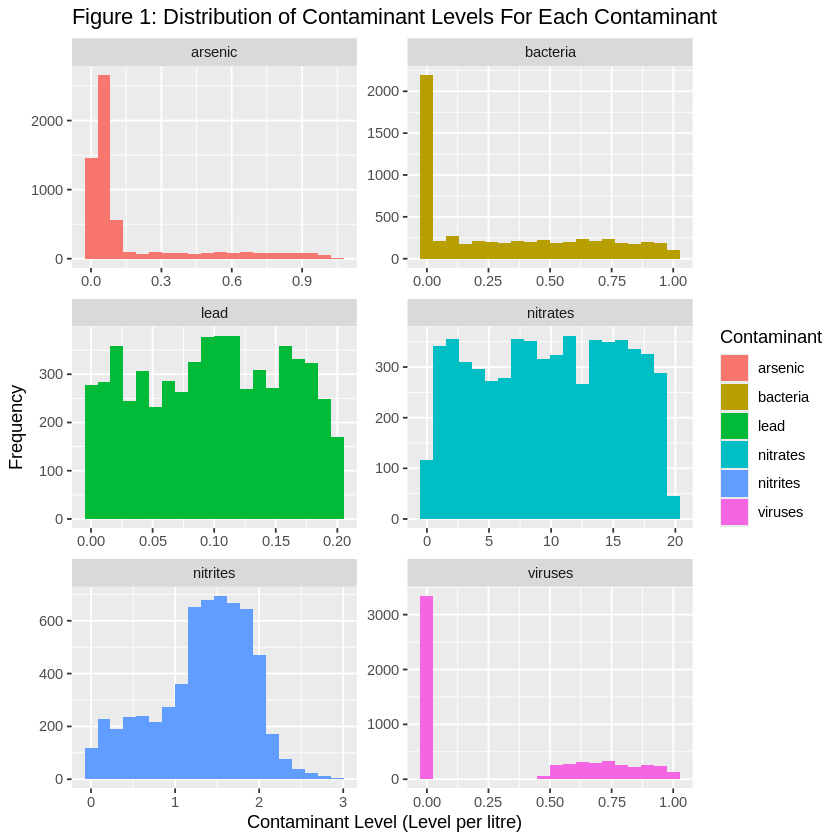

In [5]:
water_train_plot <- water_wrangled |>
                    ggplot(aes(x=level, fill = contaminant)) +
                    geom_histogram(bins = 20) +
                    facet_wrap(vars(contaminant), scales = "free", nrow = 3) +
                    labs(x=" Contaminant Level (Level per litre)", y="Frequency", fill="Contaminant") +
                    ggtitle("Figure 1: Distribution of Contaminant Levels For Each Contaminant")

water_train_plot

In [23]:
#step 1: create a recipe for the training data

water_recipe <- recipe(is_safe ~ arsenic + bacteria + viruses + lead + nitrates + nitrites, data = water_train) |>
    step_scale(all_predictors())|>
    step_center(all_predictors())
water_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 6



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



In [24]:
#step 2: create a multiple training datasets to perform cross validation

water_vfold <- vfold_cv(water_train, v = 5, strata = is_safe)

In [25]:
#step 3: create a classification model that allows us to tune the number of neighbors

water_knn <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) |>
    set_engine('kknn') |>
    set_mode('classification')

In [30]:
#step 4: create a workflow that combines the recipe, model specification and that performs the vfold cross validation

knn_workflow <- workflow() |>
    add_recipe(water_recipe) |>
    add_model(water_knn) |>
    tune_grid(resamples = water_vfold, grid = 10)

In [32]:
#step 5: collect the metrics to allow us to determine which k value is most resonable

knn_results <- knn_workflow |>
    collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.8045340,5,0.004705241,Preprocessor1_Model1
2,roc_auc,binary,0.5405224,5,0.009641995,Preprocessor1_Model1
4,accuracy,binary,0.8535699,5,0.002549544,Preprocessor1_Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
13,roc_auc,binary,0.6857200,5,0.0070686517,Preprocessor1_Model7
15,accuracy,binary,0.8835890,5,0.0003334893,Preprocessor1_Model8
15,roc_auc,binary,0.6896356,5,0.0084693488,Preprocessor1_Model8


In [40]:
water_recall <- knn_results |>
    filter(.metric == 'accuracy')

recall_plot <- ggplot(water_recall, aes(x = neighbors, y = mean)+ 
                      geom_point()+
                      geom_line()+
                      labs(x = 'Neighbors', y = 'Accuracy Estimate')+
                      ggtitle('Accuracy
                    
                        
recall_plot

ERROR: [1m[33mError[39m in `ggplot_add()`:[22m
[1m[22m[33m![39m Can't add `recall_plot` to a [34m<ggplot>[39m object.
